# Step 3 Exploratory Data Analysis

**Introduction**

IEEE Computational Intelligence Society (IEEE-CIS) works across a variety of AI and machine learning areas, including deep neural networks, fuzzy systems, evolutionary computation, and swarm intelligence. Today they’re partnering with Vesta, the world’s leading payment service company, seeking the best solutions for the fraud detection industry. The fraud prevention system used by Vesta is actually saving consumers millions of dollars per year. Researchers from the IEEE-CIS want to improve fraud detection accuracy but also the customer experiences.

**Data Source**

The data comes from Vesta’s real-world e-commerce transactions and contains a wide range of features from device type to product features, available in Kaggle competition (https://www.kaggle.com/c/ieee-fraud-detection/data). Only train_identity and train_transaction datasets will be used for this project.

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
 
3.   **Exploratory Data Analysis** 
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships

4.   Pre-processing and Training Data Development

5.   Modeling 

6.   Documentation



In [1]:
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy import stats

In [2]:
path=".../data"
os.chdir(path) 

df = pd.read_csv('step2_output.csv')
print(df.head())

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987001        0          86401            29.0         W   2755   
1        2987002        0          86469            59.0         W   4663   
2        2987003        0          86499            50.0         W  18132   
3        2987005        0          86510            49.0         W   5937   
4        2987006        0          86522           159.0         W  12308   

   card2  card3       card4  card5  ...   V312  V313  V314 V315  V316    V317  \
0  404.0  150.0  mastercard  102.0  ...    0.0   0.0   0.0  0.0   0.0     0.0   
1  490.0  150.0        visa  166.0  ...    0.0   0.0   0.0  0.0   0.0     0.0   
2  567.0  150.0  mastercard  117.0  ...  135.0   0.0   0.0  0.0  50.0  1404.0   
3  555.0  150.0        visa  226.0  ...    0.0   0.0   0.0  0.0   0.0     0.0   
4  360.0  150.0        visa  166.0  ...    0.0   0.0   0.0  0.0   0.0     0.0   

    V318  V319  V320  V321  
0    0.0   0.0   0.0 

In [3]:
print(df.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D4', 'D10', 'D15', 'M6', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', '

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- P_emaildomain: purchaser email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked to protect confidentiality
- D1-D15: timedelta, such as days between previous transaction, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Transaction Features
- The total transaction amount is heavily **right-skewed**, the same for fraud and non-fraud transaction amount. After log transformaation, the transaction amounts follow normal distributions. If we take a closer look, we see that **1.83% of all the transactions are outliers** (> 3 standard deviations), specifically, **3.31% of fraud and 1.80% of nonfraud transactions are outliers**.
- **3.24%** of transactions identified as fraud, compared to **96.76%** identified as non-fraud.
- We have highly imbalanced datasets here. The range of the indexes of fraud transactions goes from 0 to 14000+ while that of non-fraud transactions varies from 0 to around 400000. 
- We also check whether there is a difference between fraud and nonfraud transaction amount. Welch's t-Test is used to analyze the log data (since it assumes normality), and Mann-Whitney U Test is used to test the original data. Based on the results from two tests, we conclude that no difference is observed between fraud and nonfraud transaction amount, and two data have the same distributions
- TransactionID, TransactionDT are collinear features, thus we removed TransactionID.

In [4]:
trans = df[['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'addr1', 'addr2', 'P_emaildomain']]
card = df[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']]
C = df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']]
D = df[['D1', 'D4', 'D10', 'D15']]
M = df['M6']
V = df[['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']]

In [5]:
total = float(len(df))

In [6]:
trans.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
addr1             float64
addr2             float64
P_emaildomain      object
dtype: object

In [7]:
# fraud and nonfraud transactions amount
#f = df.loc[df['isFraud'] == 1]['TransactionAmt'].values
#nf = df.loc[df['isFraud'] == 0]['TransactionAmt'].values
f = df[(df['isFraud'] == 1)]
nf = df[(df['isFraud'] == 0)]

We start with the transaction amount. Original data was heavily skewed, so I took the log transformation. Any values between 0 and 1 in the original data became negative after the log transformation. The log Transaction Amount follows a normal distribution.

Text(0, 0.5, 'Probability')

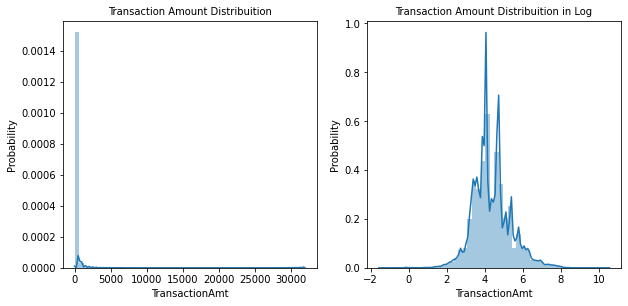

In [8]:
plt.figure(figsize=(10,10))
plt.subplot(221)
g1 = sns.distplot(df['TransactionAmt'])
g1.set_title("Transaction Amount Distribuition", fontsize=10)
g1.set_ylabel("Probability", fontsize=10)

plt.subplot(222)
g2 = sns.distplot(np.log(df['TransactionAmt']))
g2.set_title("Transaction Amount Distribuition in Log", fontsize=10)
g2.set_ylabel("Probability", fontsize=10)

(-1.3823023398503531, 10.371532734024385)

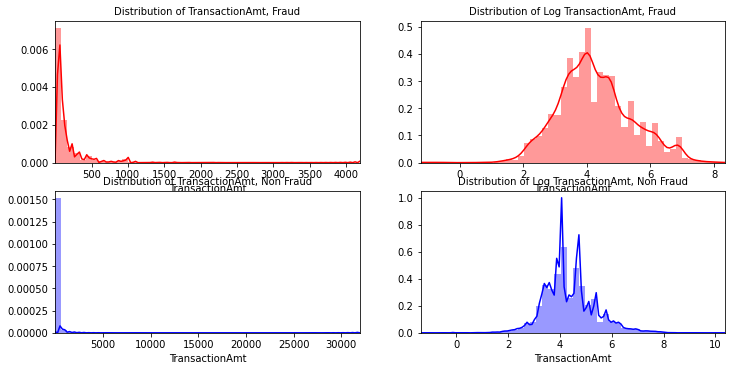

In [9]:
plt.figure(figsize=(12,12))

plt.subplot(421)
p1 = sns.distplot(f['TransactionAmt'], color='r')
p1.set_title('Distribution of TransactionAmt, Fraud', fontsize=10)
p1.set_xlim([min(f['TransactionAmt']), max(f['TransactionAmt'])])

plt.subplot(422)
p1 = sns.distplot(np.log(f['TransactionAmt']), color='r')
p1.set_title('Distribution of Log TransactionAmt, Fraud', fontsize=10)
p1.set_xlim([min(np.log(f['TransactionAmt'])), max(np.log(f['TransactionAmt']))])

plt.subplot(423)
p1 = sns.distplot(nf['TransactionAmt'], color='b')
p1.set_title('Distribution of TransactionAmt, Non Fraud', fontsize=10)
p1.set_xlim([min(nf['TransactionAmt']), max(nf['TransactionAmt'])])

plt.subplot(424)
p2 = sns.distplot(np.log(nf['TransactionAmt']), color='b')
p2.set_title('Distribution of Log TransactionAmt, Non Fraud', fontsize=10)
p2.set_xlim([min(np.log(nf['TransactionAmt'])), max(np.log(nf['TransactionAmt']))])

We can see that only 3.24% of the transactions were identified as fraud.

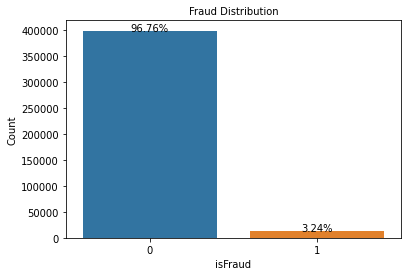

In [10]:
g3 = sns.countplot(x='isFraud', data=df)
g3.set_title("Fraud Distribution", fontsize=10)
g3.set_ylabel("Count", fontsize=10)

for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 

We plot the whole transaction amount feature across the dataset. The range of the indexes of fraud transactions goes from 0 to 14000+ while that of non-fraud transactions varies from 0 to around 400000.

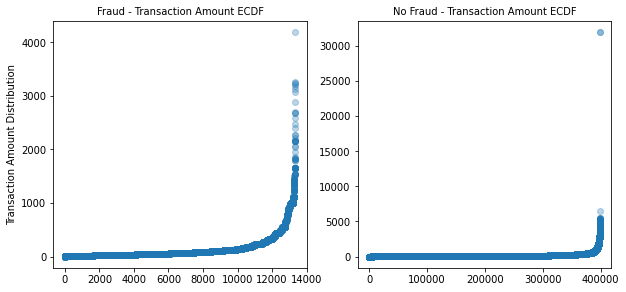

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(221)
g4 = plt.scatter(range(df[df['isFraud'] == 1].shape[0]), 
                 np.sort(df[df['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.3)
g4 = plt.title("Fraud - Transaction Amount ECDF", fontsize=10)
g4 = plt.ylabel("Transaction Amount Distribution", fontsize=10)

plt.subplot(222)
g5 = plt.scatter(range(df[df['isFraud'] == 0].shape[0]),
                 np.sort(df[df['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.3)
g5 = plt.title("No Fraud - Transaction Amount ECDF", fontsize=10)

Let's take a closer look at the distributions of fraud and non-fraud transactions and find out outliers (values larger than 3 standard deviations from the mean). 

In [12]:
print(pd.concat([df[df['isFraud'] == 1]['TransactionAmt'].quantile([.01, .05, .25, .5, .75, .95, .99]).reset_index(), 
                 df[df['isFraud'] == 0]['TransactionAmt'].quantile([.01, .05, .25, .5, .75, .95, .99]).reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01        6.64600     0.01          8.821
1  0.05       12.01000     0.05         20.165
2  0.25       32.35600     0.25         41.976
3  0.50       59.00000     0.50         67.950
4  0.75      139.61375     0.75        117.000
5  0.95      554.00000     0.95        454.950
6  0.99      994.00000     0.99       1304.330


In [13]:
def outliers(df, f, nf): 
    out1 = df[(df - df.mean()) > (3 * df.std())]
    out1_removed = df[(df - df.mean()) <= (3 * df.std())]
    
    out2 = f[(f - f.mean()) > (3 * f.std())]
    out2_removed = f[(f - f.mean()) <= (3 * f.std())]
    
    out3 = nf[(nf - nf.mean()) > (3 * nf.std())]
    out3_removed = nf[(nf - nf.mean()) <= (3 * nf.std())]
    
    print("Total outlier %d, fraud %d, nonfraud %d" % 
          (len(out1), len(out2), len(out3)))
    print("Within 3 std dev total observations %d, fraud %d, nonfraud %d" % 
          (len(out1_removed), len(out2_removed), len(out3_removed)))
    print("Percentage of total outliers %.4f, fraud %.4f, nonfraud %.4f" % 
          (round((len(out1) / len(out1_removed) )*100, 4), 
           round((len(out2) / len(out2_removed) )*100, 4), 
           round((len(out3) / len(out3_removed) )*100, 4)))

    return

In [14]:
outliers(df['TransactionAmt'], f['TransactionAmt'], nf['TransactionAmt'])

Total outlier 7421, fraud 428, nonfraud 7057
Within 3 std dev total observations 404516, fraud 12926, nonfraud 391526
Percentage of total outliers 1.8345, fraud 3.3112, nonfraud 1.8024


In [ ]:
# Remove TransactionAmt outliers
#dfn = df[np.abs(df.TransactionAmt - df.TransactionAmt.mean()) <= (3 * df.TransactionAmt.std())]
#print(dfn.shape)
#print(dfn.TransactionAmt.describe().T)


We will now perform statistical tests to determine whether the difference between fraud and nonfraud transactions is statistically significant:

- We use **Welch's t-test**. Welch's t test is based on the assumption that two samples follow normal distributions with unequal variances. Here we need to apply the log transformation on both samples to proceed. The difference between Welch's t and Student's t is that Student's t assumes equal variances while Welch's does not.
    - Null Hypothesis: mean of sample 1 is equal to the mean of sample 2
    - Alternative Hypothesis: mean of sample 1 is not equal to the mean of sample 2
    - We reject the null if p-value is less than alpha, where alpha = 0.05 commonly
- We also do a **Mann-Whitney U test** on original data. U test is a nonparametric test for comparing independent samples that are not normally distributed (or generally two samples do not follow Gaussian distribution), an alternative version of Student's t
    - Null Hypothesis: the distributions of both samples are equal
    - Alternative Hypothesis: the distributions are not equal
    - We reject the null if p-value is less than alpha, where alpha = 0.05 commonly

In [15]:
# first, let's check mean and standard deviation of fraud and nonfraud transaction amount
mu1, s1, mu2, s2 = f['TransactionAmt'].mean(), f['TransactionAmt'].std(), nf['TransactionAmt'].mean(), nf['TransactionAmt'].std()
print("Fraud transaction amount mean %.4f and std %.4f, Nonfraud transaction amount mean %.4f and std %.4f" % (mu1, s1, mu2, s2))

Fraud transaction amount mean 144.7879 and std 239.1932, Nonfraud transaction amount mean 141.1726 and std 263.0481


In [16]:
# now, apply the log transformation
log_f = np.log(f['TransactionAmt'])
log_nf = np.log(nf['TransactionAmt'])

mu1, s1, mu2, s2 = log_f.mean(), log_f.std(), log_nf.mean(), log_nf.std()
print("Log Fraud transaction amount mean %.4f and std %.4f, Log Nonfraud transaction amount mean %.4f and std %.4f" % (mu1, s1, mu2, s2))

Log Fraud transaction amount mean 4.2552 and std 1.1513, Log Nonfraud transaction amount mean 4.3693 and std 0.9786


In [17]:
# Welch's t test

def welch_dof(x, y):  
    ## Welch's t Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    print("Welch's Degrees of Freedom: %.4f" % dof)

def welch_ttest(x, y): 
    dof = welch_dof(x, y)
    t, p = stats.ttest_ind(x, y, equal_var = False)
    print("Welch's t-test: %.4f, p-value: %.4f" % (t, p))
    
welch_ttest(log_f, log_nf)

Welch's Degrees of Freedom: 14007.0060
Welch's t-test: -11.3113, p-value: 0.0000


In [18]:
# Mann-Whitney's U

from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(f['TransactionAmt'], nf['TransactionAmt'])
print("Man-Whiteney's U-test: %.4f, p-value: %.4f" % (stat, p))

Man-Whiteney's U-test: 2472538763.0000, p-value: 0.0000


**Product Distributions**

- Over 99% of Products have Product Code of W (84.88%) or C(14.74%).
- Most fraud transactions of Product W are less than 1000, only small fraction goes beyond 3000. While nonfraud transaction amount of Product W goes from 0 to 5000.
- The largest fraud transaction amount of Product C is higher then the largest nonfraud transaction amount.

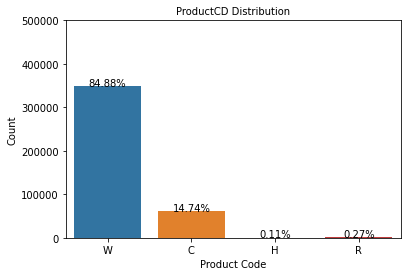

In [19]:
g6 = sns.countplot(x='ProductCD', data=df)
g6.set_title("ProductCD Distribution", fontsize=10)
g6.set_xlabel("Product Code", fontsize=10)
g6.set_ylabel("Count", fontsize=10)
g6.set_ylim(0,500000)

for p in g6.patches:
    height = p.get_height()
    g6.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 

We see that over 99% of Products have Product Code of W (84.88%) or C(14.74%).

Let's check for any differences between fraud and non-fraud transaction amounts by products.

Text(0, 0.5, 'Transaction Amount')

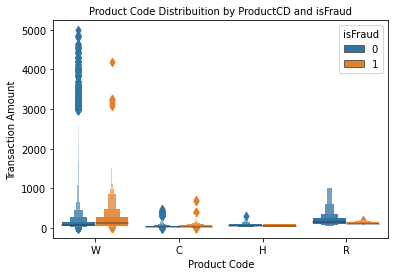

In [20]:
g7 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', data=df[df['TransactionAmt'] <= 5000] )
g7.set_title("Product Code Distribuition by ProductCD and isFraud", fontsize=10)
g7.set_xlabel("Product Code", fontsize=10)
g7.set_ylabel("Transaction Amount", fontsize=10)

**Addresses**

Text(0, 0.5, 'Counts')

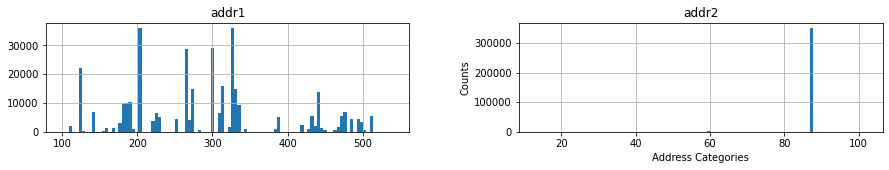

In [21]:
addr = df[['addr1', 'addr2']]
addr.hist(bins=100, figsize=(15,2))
plt.xlabel("Address Categories", fontsize=10)
plt.ylabel("Counts",fontsize=10)

**Purchaser email domain**

Group all email domains by companies/enterprises. Let values with < 500 entries be Others

- The top three email domains are Gmail (46.78%), followed by Yahoo (21.76%) and Microsoft (12.26%) 


In [22]:
df['P_emaildomain'].unique()

array(['gmail.com', 'outlook.com', 'yahoo.com', 'mail.com', 'hotmail.com',
       'verizon.net', 'aol.com', 'me.com', 'anonymous.com', 'comcast.net',
       'optonline.net', 'cox.net', 'rocketmail.com', 'prodigy.net.mx',
       'icloud.com', 'live.com.mx', 'gmail', 'live.com', 'att.net',
       'ymail.com', 'sbcglobal.net', 'juno.com', 'charter.net',
       'bellsouth.net', 'msn.com', 'q.com', 'yahoo.com.mx',
       'centurylink.net', 'servicios-ta.com', nan, 'earthlink.net',
       'hotmail.es', 'cfl.rr.com', 'roadrunner.com', 'netzero.net',
       'netzero.com', 'frontier.com', 'aim.com', 'windstream.net',
       'frontiernet.net', 'cableone.net', 'gmx.de', 'yahoo.fr', 'twc.com',
       'web.de', 'suddenlink.net', 'sc.rr.com', 'ptd.net',
       'embarqmail.com', 'yahoo.de', 'hotmail.fr', 'hotmail.de',
       'outlook.es', 'mac.com', 'hotmail.co.uk', 'yahoo.co.uk', 'live.fr',
       'yahoo.es', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

In [23]:
df.loc[df['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google Mail'

df.loc[df['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk', 'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                 'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
df.loc[df['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 'hotmail.es','hotmail.co.uk', 
                                 'hotmail.de','outlook.es', 'live.com', 'live.fr', 
                                 'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df.loc[df.P_emaildomain.isin(df.P_emaildomain.value_counts()[df.P_emaildomain.value_counts() <= 500 ].index), 'P_emaildomain'] = "Others"
df.P_emaildomain.fillna("Unknown", inplace=True)

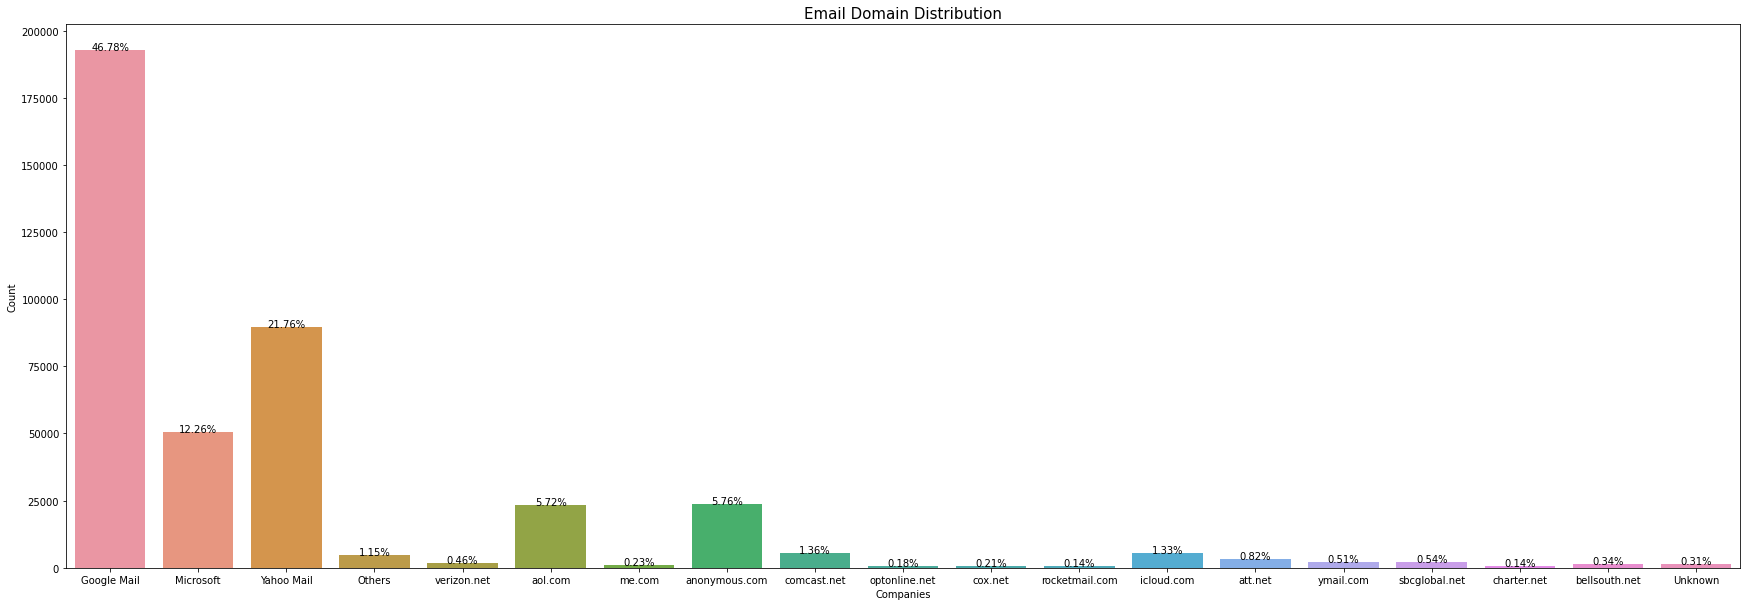

In [24]:
plt.figure(figsize=(30,10))
g = sns.countplot(x='P_emaildomain', data=df)
g.set_title("Email Domain Distribution", fontsize=15)
g.set_xlabel("Companies", fontsize=10)
g.set_ylabel("Count", fontsize=10)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 

### Card Features

card4 and card6 are categorical features, the rest are numerical features. card4 is the issue company and card6 is the card type 

- When transaction amount < 5000, 33.20% of people use Mastercard and 65.56% use Visa. 
- Discover card accounts for only 0.90% of all transactions but has the largest number of fraudulent transactions. 
- All transactions are paid by either debit or credit cards. Most people use debit card (79.77%), followed by credit card (19.90%); however, there are more fradulent transactions made by credit card than debit card.


In [25]:
card.dtypes

card1      int64
card2    float64
card3    float64
card4     object
card5    float64
card6     object
dtype: object

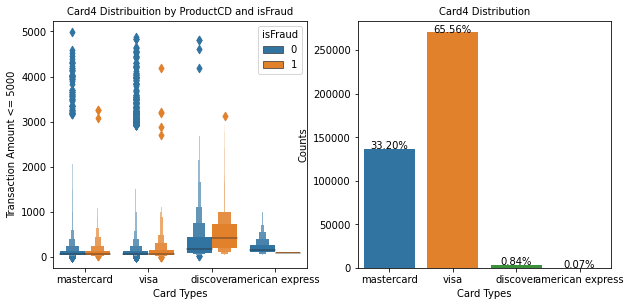

In [26]:
plt.figure(figsize=(10,10))
plt.subplot(221)
g8 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', data=df[df['TransactionAmt'] <= 5000])
g8.set_title("Card4 Distribuition by ProductCD and isFraud", fontsize=10)
g8.set_xlabel("Card Types", fontsize=10)
g8.set_ylabel("Transaction Amount <= 5000", fontsize=10)

plt.subplot(222)
g9 = sns.countplot(x='card4', data=df)
g9.set_title("Card4 Distribution", fontsize=10)
g9.set_xlabel("Card Types", fontsize=10)
g9.set_ylabel("Counts", fontsize=10)
for p in g9.patches:
    height = p.get_height()
    g9.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 

When transaction amount is less than 5000, over 99% of cards are Mastercard (33.20%) and Visa (65.56%). Discover card accounts for only 0.90% of all transactions but has the largest number of fraudulent transactions. Besides, all transactions are paid by either debit or credit cards. Most people use debit card (79.77%), followed by credit card (19.90%); however, there are more fradulent transactions made by credit card than debit card.

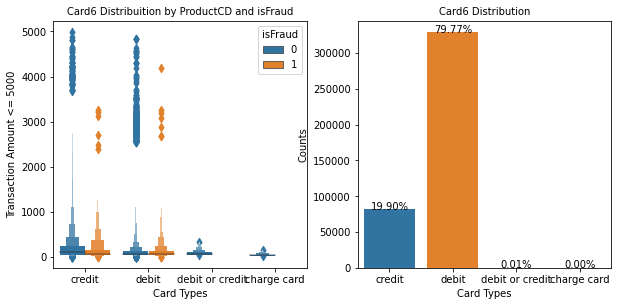

In [27]:
plt.figure(figsize=(10,10))
plt.subplot(221)
g10 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', data=df[df['TransactionAmt'] <= 5000])
g10.set_title("Card6 Distribuition by ProductCD and isFraud", fontsize=10)
g10.set_xlabel("Card Types", fontsize=10)
g10.set_ylabel("Transaction Amount <= 5000", fontsize=10)

plt.subplot(222)
g11 = sns.countplot(x='card6', data=df)
g11.set_title("Card6 Distribution", fontsize=10)
g11.set_xlabel("Card Types", fontsize=10)
g11.set_ylabel("Counts", fontsize=10)
for p in g11.patches:
    height = p.get_height()
    g11.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 

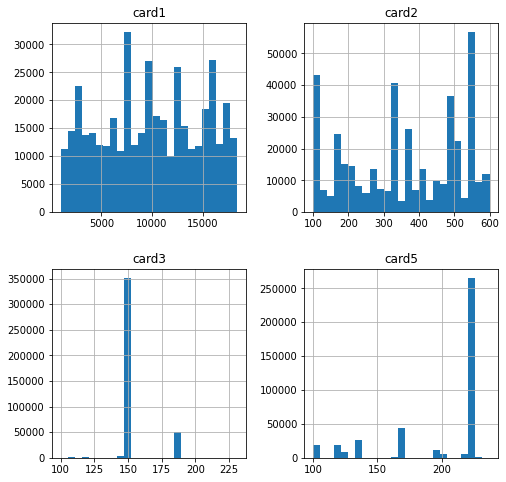

In [28]:
card.hist(bins=25, figsize =(8,8))
plt.show()

We plot the Pearson correlation coefficient heatmap to study correlations among response variables and identify potential multi-collinearity.

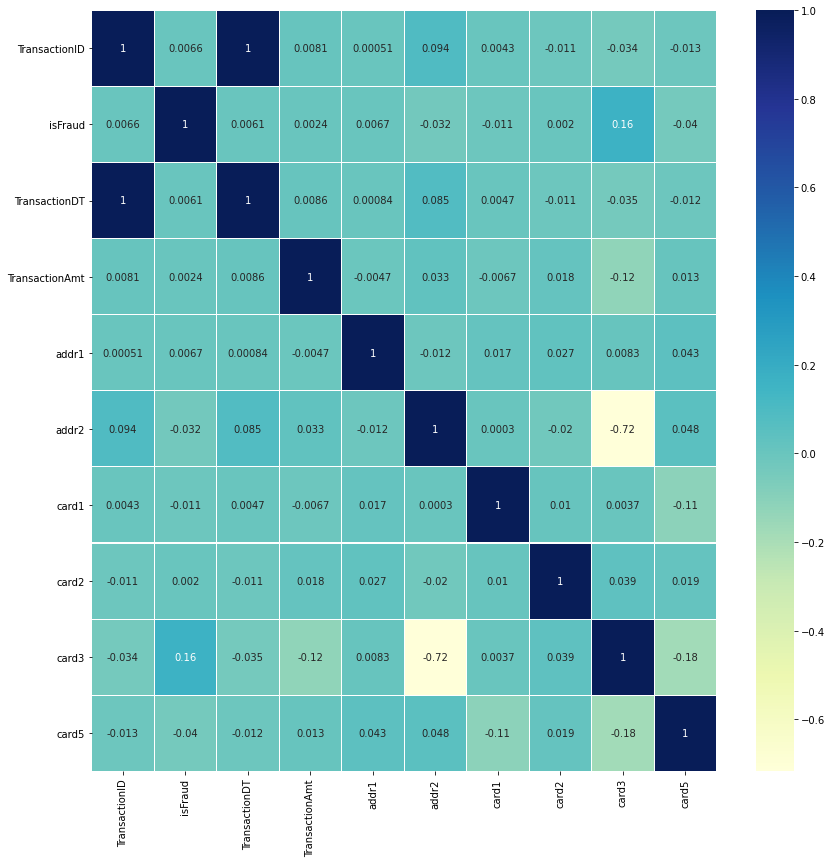

In [29]:
df2 = df[['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'addr1', 'addr2', 
         'card1', 'card2', 'card3', 'card5']]
plt.figure(figsize=(14,14))
sns.heatmap(df2.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

We're supposed to remove feature columns with a strong correlation (correlation > 0.8): TransactionID, TransactionDT. However, TransactionID is a core feature here, so we will drop it during the modeling step.

In [30]:
#Calculate the correlation coefficients
corr = df2.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.8).any()
raw = corr.loc[m, m]
raw.round(2).style.background_gradient(cmap='coolwarm')

,isFraud,TransactionAmt,addr1,addr2,card1,card2,card3,card5
isFraud,1.000000,0.000000,0.010000,-0.030000,-0.010000,0.000000,0.160000,-0.040000
TransactionAmt,0.000000,1.000000,-0.000000,0.030000,-0.010000,0.020000,-0.120000,0.010000
addr1,0.010000,-0.000000,1.000000,-0.010000,0.020000,0.030000,0.010000,0.040000
addr2,-0.030000,0.030000,-0.010000,1.000000,0.000000,-0.020000,-0.720000,0.050000
card1,-0.010000,-0.010000,0.020000,0.000000,1.000000,0.010000,0.000000,-0.110000
card2,0.000000,0.020000,0.030000,-0.020000,0.010000,1.000000,0.040000,0.020000
card3,0.160000,-0.120000,0.010000,-0.720000,0.000000,0.040000,1.000000,-0.180000
card5,-0.040000,0.010000,0.040000,0.050000,-0.110000,0.020000,-0.180000,1.000000


### C Feature

- We can see that except for C3, C features are multicollinear with each other. Thus, we only keep C3 feature and remove the rest.

In [31]:
C.dtypes

C1     float64
C2     float64
C3     float64
C4     float64
C5     float64
C6     float64
C7     float64
C8     float64
C9     float64
C10    float64
C11    float64
C12    float64
C13    float64
C14    float64
dtype: object

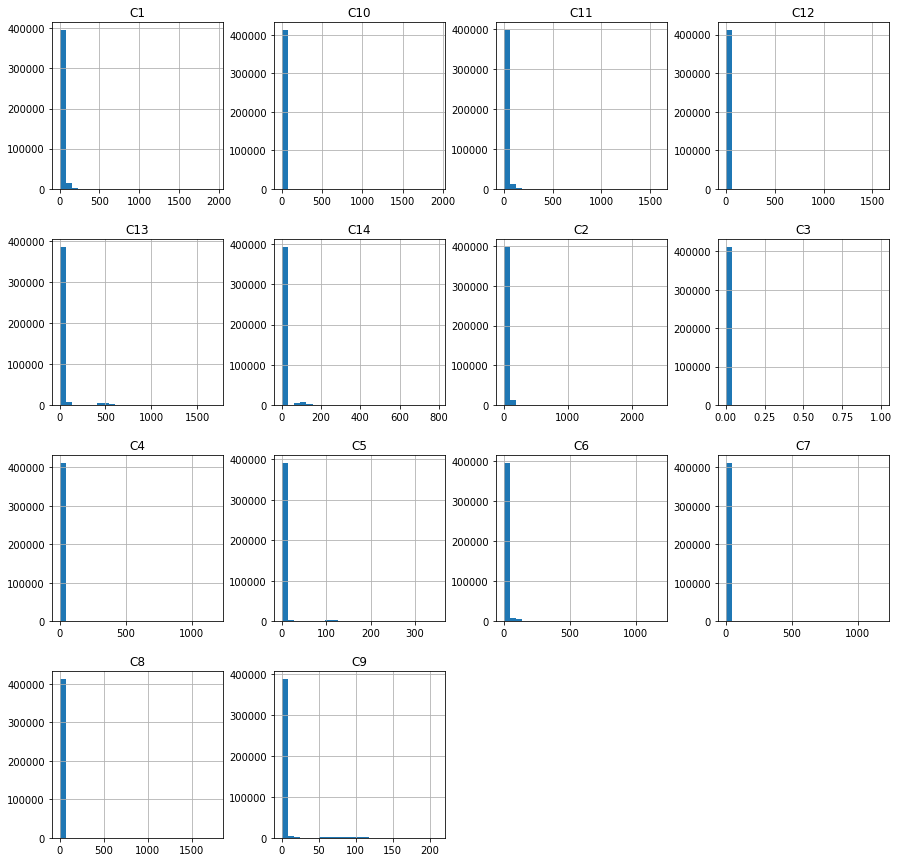

In [32]:
C.hist(bins=25, figsize =(15,15))
plt.show()

We plot the heatmap and remove feature columns with coefficient>0.8

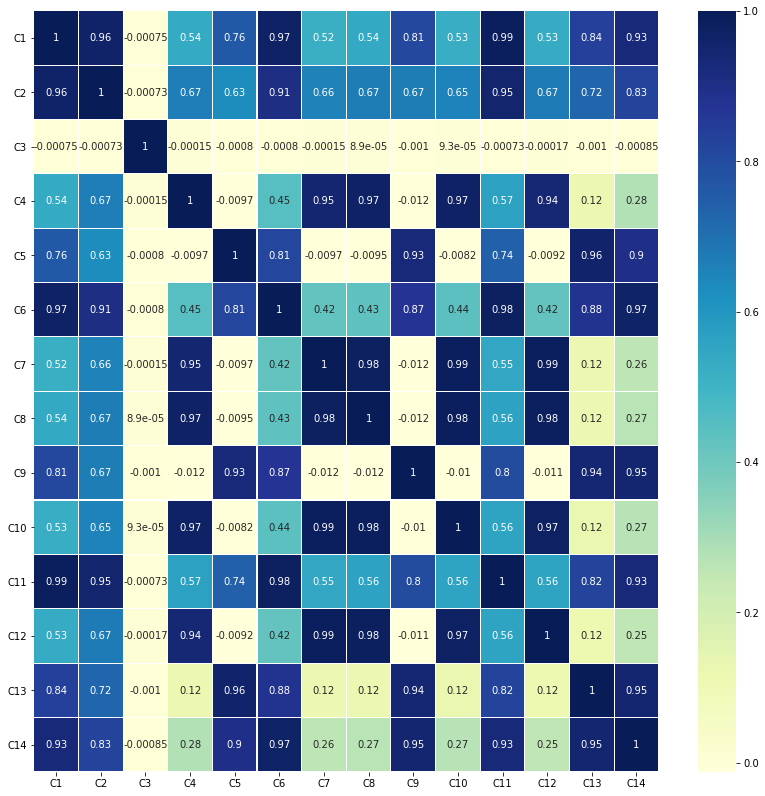

In [33]:
plt.figure(figsize=(14,14))
sns.heatmap(C.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

In [34]:
#Calculate the correlation coefficients and remove columns with r>0.8
corr = C.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.8).any()
raw = corr.loc[m, m]
raw.round(2).style.background_gradient(cmap='coolwarm')

,C3
C3,1.000000


In [35]:
df = df.drop(['C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'], axis = 1)
print(df.shape)
print(df.head())

(411937, 189)
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987001        0          86401            29.0         W   2755   
1        2987002        0          86469            59.0         W   4663   
2        2987003        0          86499            50.0         W  18132   
3        2987005        0          86510            49.0         W   5937   
4        2987006        0          86522           159.0         W  12308   

   card2  card3       card4  card5  ...   V312  V313  V314 V315  V316    V317  \
0  404.0  150.0  mastercard  102.0  ...    0.0   0.0   0.0  0.0   0.0     0.0   
1  490.0  150.0        visa  166.0  ...    0.0   0.0   0.0  0.0   0.0     0.0   
2  567.0  150.0  mastercard  117.0  ...  135.0   0.0   0.0  0.0  50.0  1404.0   
3  555.0  150.0        visa  226.0  ...    0.0   0.0   0.0  0.0   0.0     0.0   
4  360.0  150.0        visa  166.0  ...    0.0   0.0   0.0  0.0   0.0     0.0   

    V318  V319  V320 V321  
0    0.0

### Time Delta Feature (D)

In [36]:
D.dtypes

D1     float64
D4     float64
D10    float64
D15    float64
dtype: object

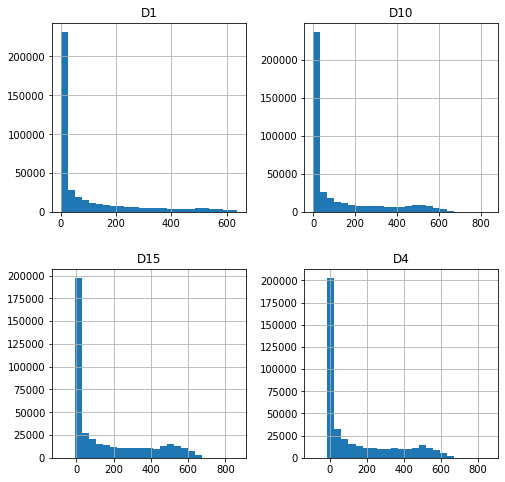

In [37]:
D.hist(bins=25, figsize =(8,8))
plt.show()

We create a pairplot of a sample of 1000 fraud and nonfraud data to study potential feature interations. We may later create new features based on relationships among these data.

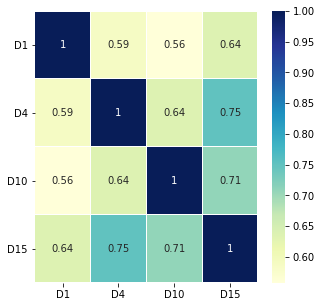

In [38]:
plt.figure(figsize=(5,5))
sns.heatmap(D.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

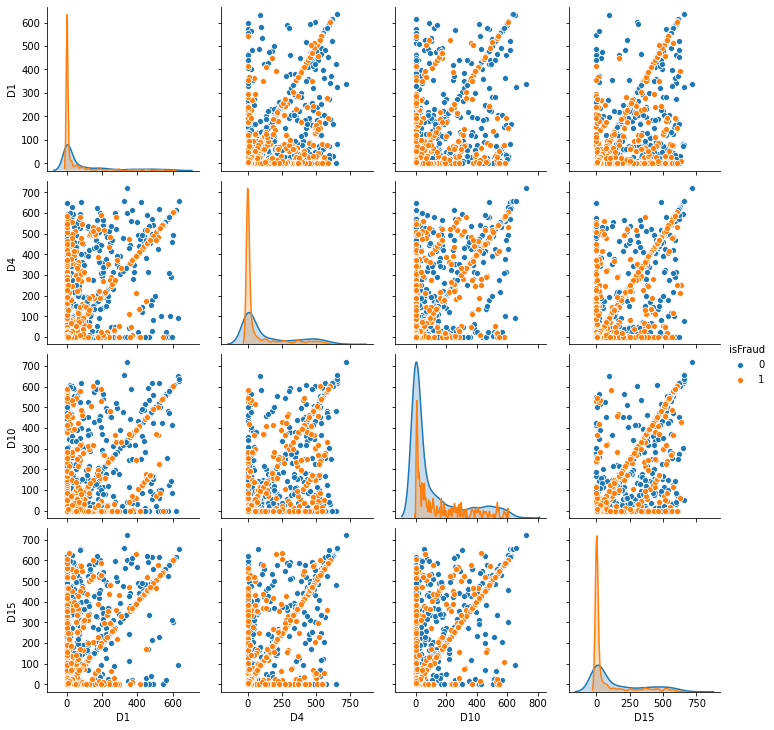

In [39]:
# we will look at a sample of 1000 fraud and nonfraud data
sample = pd.concat([df.loc[df['isFraud'] == 0].sample(1000), df.loc[df['isFraud'] == 1].sample(1000)])
sns.pairplot(sample, hue='isFraud', vars=D)
plt.show()

### Match Feature (M)

- 37.62% of transaction information are matched, compared to 44.11% of unmatched information.

In [40]:
M.head()

0    T
1    F
2    F
3    T
4    F
Name: M6, dtype: object

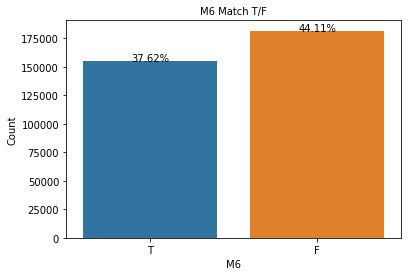

In [41]:
g12 = sns.countplot(x='M6', data=df)
g12.set_title("M6 Match T/F", fontsize=10)
g12.set_ylabel("Count", fontsize=10)

for p in g12.patches:
    height = p.get_height()
    g12.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 

### V Features

In [42]:
V.dtypes

V12     float64
V13     float64
V14     float64
V15     float64
V16     float64
         ...   
V317    float64
V318    float64
V319    float64
V320    float64
V321    float64
Length: 169, dtype: object

In [43]:
#Calculate the correlation coefficients and remove columns with r>0.8
corr = V.corr()
drop = (corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.8).any()
to_drop = corr.loc[drop, drop]
#m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.8).any()
#raw = corr.loc[m, m]
#raw.round(2).style.background_gradient(cmap='coolwarm')

In [44]:
print(to_drop.columns.tolist())

['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V57', 'V58', 'V59', 'V60', 'V63', 'V64', 'V65', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V79', 'V80', 'V81', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V101', 'V102', 'V103', 'V111', 'V112', 'V113', 'V117', 'V119', 'V123', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V285', 'V287', 'V288', 'V289', 'V290', 'V292', 'V293', 'V294', 'V295', 'V296', 'V298', 'V300', 'V301', 'V302', 'V303', 'V304', 'V306', 'V307', 'V308', 'V309', 'V310', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']


In [45]:
df = df.drop(to_drop, axis = 1)
print(df.shape)
print(df.head())

(411937, 60)
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987001        0          86401            29.0         W   2755   
1        2987002        0          86469            59.0         W   4663   
2        2987003        0          86499            50.0         W  18132   
3        2987005        0          86510            49.0         W   5937   
4        2987006        0          86522           159.0         W  12308   

   card2  card3       card4  card5  ... V281  V282  V283 V284  V286  V291  \
0  404.0  150.0  mastercard  102.0  ...  0.0   1.0   1.0  0.0   0.0   1.0   
1  490.0  150.0        visa  166.0  ...  0.0   1.0   1.0  0.0   0.0   1.0   
2  567.0  150.0  mastercard  117.0  ...  0.0   0.0   0.0  0.0   0.0   1.0   
3  555.0  150.0        visa  226.0  ...  0.0   1.0   1.0  0.0   0.0   1.0   
4  360.0  150.0        visa  166.0  ...  0.0   1.0   1.0  0.0   0.0   1.0   

   V297  V299  V305 V311  
0   0.0   0.0   1.0  0.0  
1   0.0

In [46]:
df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V281,V282,V283,V284,V286,V291,V297,V299,V305,V311
0,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2987005,0,86510,49.000,W,5937,555.0,150.0,visa,226.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,2987006,0,86522,159.000,W,12308,360.0,150.0,visa,166.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411932,3577534,0,15811030,67.505,C,5812,408.0,185.0,mastercard,224.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
411933,3577536,0,15811049,39.500,W,10444,225.0,150.0,mastercard,224.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
411934,3577537,0,15811079,30.950,W,12037,595.0,150.0,mastercard,224.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
411935,3577538,0,15811088,117.000,W,7826,481.0,150.0,mastercard,224.0,...,0.0,2.0,7.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0


Save and export

In [47]:
df.to_csv('step3_output.csv', index=False)